In [1]:
import pyspark

In [2]:
sc = pyspark.SparkContext('local[*]')

In [3]:
sqlContext = pyspark.SQLContext(sc)

In [4]:
amznInstantVideo = sqlContext.read.json("AmznInstantVideo.json")

In [5]:
amznInstantVideo.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [6]:
amznInstantVideo.registerTempTable('reviews')

In [7]:
sqlContext.sql("select distinct overall from reviews order by overall desc").show()

+-------+
|overall|
+-------+
|    5.0|
|    4.0|
|    3.0|
|    2.0|
|    1.0|
+-------+



Let's recode the overall score to __positive__, __negative__, or __neutral__
* __Positive__: overall > 3
* __Negative__: overall < 3
* __Neutral__: overall == 3

We'll use a User Defined Function to add this column.

In [8]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType
 
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else -1, IntegerType())
amznInstantVideo = amznInstantVideo.withColumn("overall_recode",udf(amznInstantVideo.overall))

In [9]:
amznInstantVideo.select("reviewText", "overall", "overall_recode").show(10)

+--------------------+-------+--------------+
|          reviewText|overall|overall_recode|
+--------------------+-------+--------------+
|I had big expecta...|    2.0|            -1|
|I highly recommen...|    5.0|             1|
|This one is a rea...|    1.0|            -1|
|Mysteries are int...|    4.0|             1|
|This show always ...|    5.0|             1|
|I discovered this...|    5.0|             1|
|It beats watching...|    3.0|            -1|
|There are many ep...|    3.0|            -1|
|This is the best ...|    5.0|             1|
|Not bad.  Didn't ...|    3.0|            -1|
+--------------------+-------+--------------+
only showing top 10 rows



In [10]:
from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

([<matplotlib.axis.XTick at 0x7f13e0c60f28>,
 <a list of 2 Text xticklabel objects>)

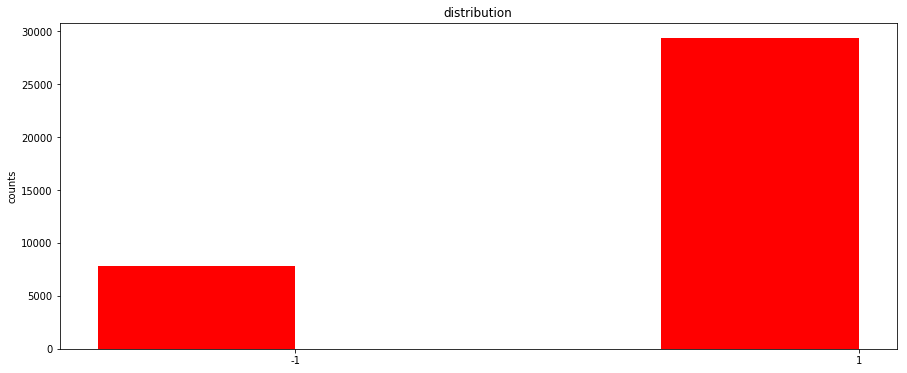

In [11]:
plt.rcParams['figure.figsize'] = (15, 6)
 
statuses = amznInstantVideo.groupBy('overall_recode').count().collect()
categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind + width/2., categories)

In [13]:
from pyspark.ml.feature import Tokenizer, Word2Vec

tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenized_text").transform(amznInstantVideo)

word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol="tokenized_text", outputCol="w2v_vector").fit(tokenizer)

w2vdf=word2Vec.transform(tokenizer)

In [14]:
w2vdf.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- overall_recode: integer (nullable = true)
 |-- tokenized_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v_vector: vector (nullable = true)



In [16]:
w2vdf.select("overall_recode", "reviewText", "tokenized_text", "w2v_vector").show(10)

+--------------+--------------------+--------------------+--------------------+
|overall_recode|          reviewText|      tokenized_text|          w2v_vector|
+--------------+--------------------+--------------------+--------------------+
|            -1|I had big expecta...|[i, had, big, exp...|[-0.0370439446113...|
|             1|I highly recommen...|[i, highly, recom...|[0.00302896804805...|
|            -1|This one is a rea...|[this, one, is, a...|[0.00766816143340...|
|             1|Mysteries are int...|[mysteries, are, ...|[0.02922427154819...|
|             1|This show always ...|[this, show, alwa...|[-0.0129554296898...|
|             1|I discovered this...|[i, discovered, t...|[0.00260004208480...|
|            -1|It beats watching...|[it, beats, watch...|[-0.0328859328292...|
|            -1|There are many ep...|[there, are, many...|[-0.0305897704939...|
|             1|This is the best ...|[this, is, the, b...|[-0.0207668397751...|
|            -1|Not bad.  Didn't ...|[no